# Week 4: Interpretable Machine Learning for Data Science

**Problem**: You have been mandated by a large wine-making company in Valais to discover the key chemical factors that determine the quality of wine and build an interpretable model that will help their cellar masters make decisions daily.

## Settings things up (15')

This week will require quite a lot of autonomy on your part, but we will guide you with this high-level notebook. First, take the following steps:

- Install [Poetry](https://python-poetry.org). 
- Then use Poetry to create a virtual environment:

  ```sh
  poetry install
  ```

- Then restart VS Code and add the kernel that corresponds to the environment created by Poetry.

Then, let's set up [black](https://github.com/psf/black), which is a highly encouraged best-practice for all your Python projects. That way, you never have to worry and debate about code formatting anymore. By using it, you agree to cede control over minutiae of hand-formatting. In return, Black gives you speed, determinism, and freedom from `pycodestyle` nagging about formatting. You will save time and mental energy for more important matters.

In [230]:
# install lib to import data
!pip install ucimlrepo

In [231]:
!poetry install
!poetry run ipython kernel install --user --name=w4-xai-ds

Installing dependencies from lock file

No dependencies to install or update
Installed kernelspec w4-xai-ds in /home/franciscoribeiro/.local/share/jupyter/kernels/w4-xai-ds


In [232]:
import jupyter_black

jupyter_black.load()

Here are the libraries you will most likely need and use during this week:

- `numpy` for basic scientific computing and `scipy` for statistical testing.
- `pandas` or `polars` for dataset manipulation. Polars is highly recommended, because it is [awesome](https://github.com/ddotta/awesome-polars). Instructions below will refer to the Polars API.
- `seaborn` for statistical data visualization, but `matplotlib` is always needed anyway. Use both!
- `shap` will be used for [interpretability](https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).
- `sklearn` and `xgboost` will be used for training models. You may import them later when you need them.

In [233]:
# import all libs to use in this notebook
import numpy as np
import scipy
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import shap
import sklearn
import xgboost as xgb
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.metrics import confusion_matrix, classification_report

## Fetch the data (15')

Here we have a very nice package that can do everything for us (aka `ucimlrepo`). Let's use it!

Take a look at [the website](https://archive.ics.uci.edu/dataset/186/wine+quality) for details.

In [234]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

df = wine_quality.data.original

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets


wineColor = df["color"]

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [235]:
# Check original data set
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Now, let's check that the data have the correct shape to ensure they have been loaded as expected.

Calculate how many samples and features we have in total, how many are red or white wines, how many are good or bad wines, etc.

In [236]:
# Count the number of red and white wines
red_wine_count = df[df["color"] == "red"].shape[0]
white_wine_count = df[df["color"] == "white"].shape[0]

print(f"Number of red wines: {red_wine_count}")
print(f"Number of white wines: {white_wine_count}")

Number of red wines: 1599
Number of white wines: 4898


In [237]:
# Count the number of good and bad wines
goodWine = df[df["quality"] >= 6].shape[0]
badWines = df[df["quality"] < 6].shape[0]

print(f"Number of good wines: {goodWine}")
print(f"Number of bad wines: {badWines}")

Number of good wines: 4113
Number of bad wines: 2384


In [238]:
print(X.shape)
print(y.shape)

(6497, 11)
(6497, 1)


In [239]:
X.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [240]:
y.describe()

,quality
count,6497.000000
mean,5.818378
std,0.873255
min,3.000000
25%,5.000000
50%,6.000000
75%,6.000000
max,9.000000


## Data Exploration (1h30)

We now will inspect the features one-by-one, and try to understand their dynamics, especially between white and red wines.

- Use `Dataframe.describe` to display statistics on each feature. Do the same for red wines only, and white wines only. Do you notice any clear difference?
- Compute the effect size by computing the [strictly standardized mean difference](https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference) (SSMD) between the red and white wines for each feature. 

In [241]:
X.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [242]:
# See mean and std for red and white
df[df["color"] == "red"].describe()
df_red = df[df["color"] == "red"]

In [243]:
df[df["color"] == "white"].describe()
df_white = df[df["color"] == "white"]

In [244]:
numeric_features = [
    "fixed_acidity",
    "volatile_acidity",
    "citric_acid",
    "residual_sugar",
    "chlorides",
    "free_sulfur_dioxide",
    "total_sulfur_dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

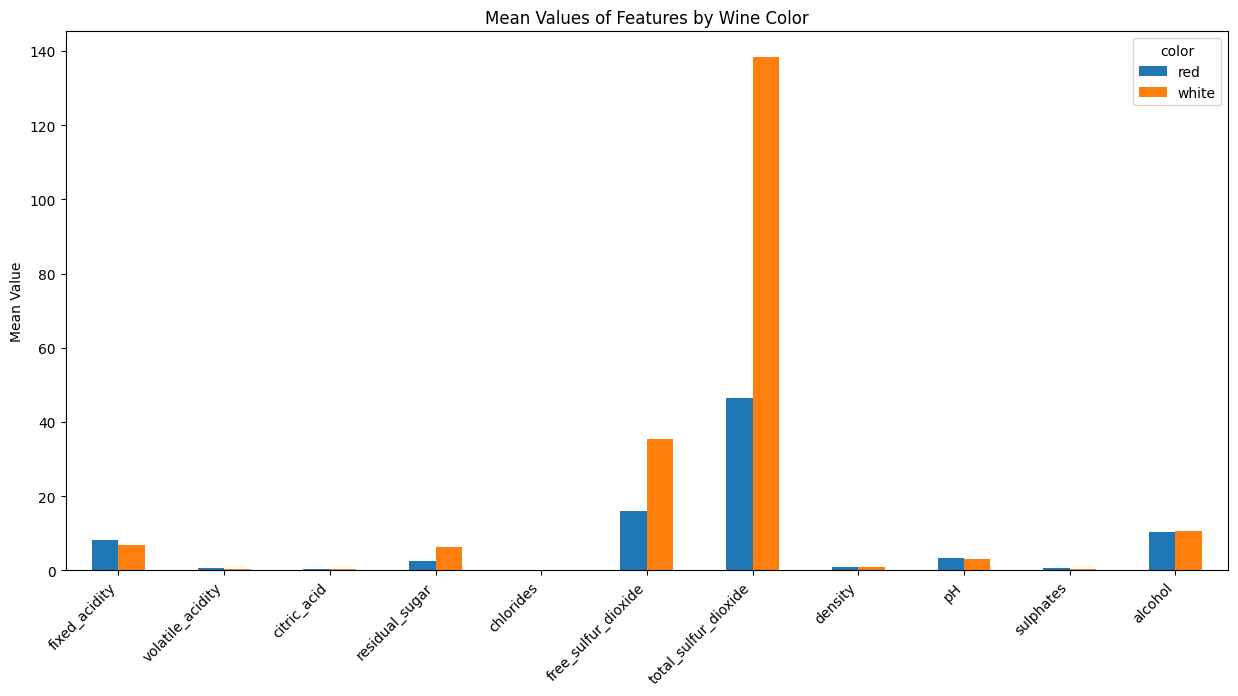

In [245]:
# Calculating the mean values for red and white wines
mean_values = df.groupby("color")[numeric_features].mean().transpose()

# Plotting the barplot comparing mean values between red and white
mean_values.plot(kind="bar", figsize=(15, 7))
plt.title("Mean Values of Features by Wine Color")
plt.ylabel("Mean Value")
plt.xticks(rotation=45, ha="right")
plt.show()

## differences between red and white
- we can see big differences between white wine and red whine in the features
 - *total_sulfur_dioxide* : We can see that mean of sulfur dioxide is almost 3 times higer in red wine that in white wine 
- There is a significant imbalance between 'good' and 'bad' wines, with the majority of wines being classified as 'bad' based on the quality score.

Now let's go a bit deeper into the same analysis, using more visual tools:

- For every feature, plot boxplots, violinplots or histograms for red and white wines. What can you infer? **If you feel a bit more adventurous**, plot the Cumulative Distribution Function (CDF) of the feature for white and red wines, and compute the [Kullback-Leibler divergence](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) (or entropy) between them. Explain why this might be useful.
- Plot the correlation matrix of all features as heatmaps, one for red and one for white wines. How do they differ? What can you infer?

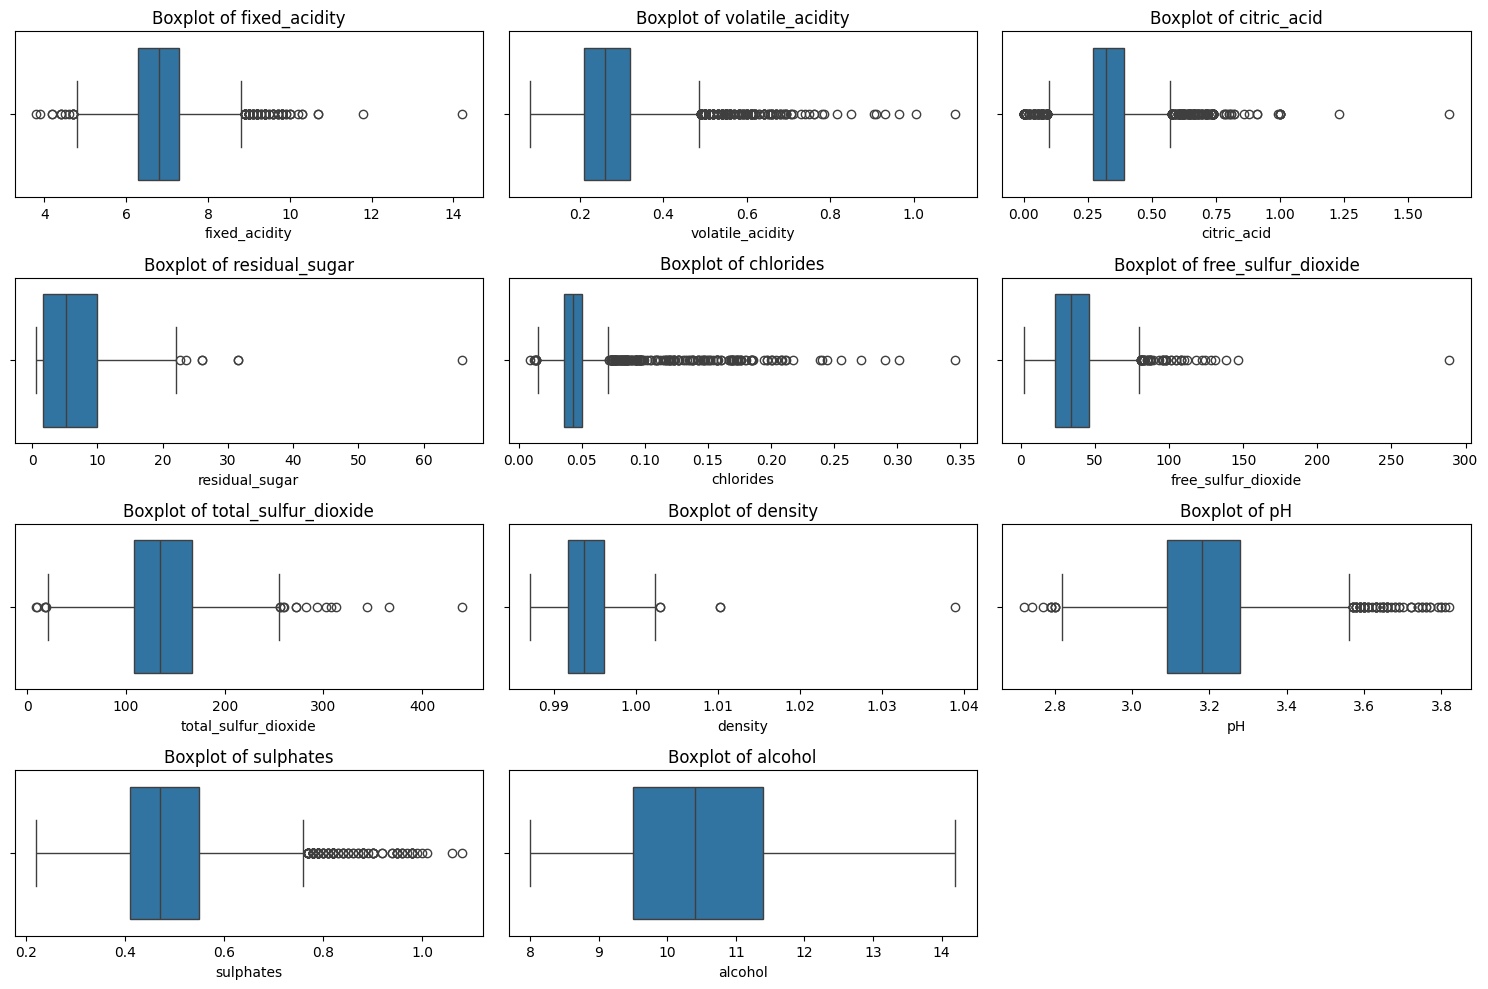

In [246]:
# plotting through seaborn
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df_white[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

/tmp/ipykernel_148848/3268801676.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="color", y=feature, data=df, palette="Set2")
/tmp/ipykernel_148848/3268801676.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="color", y=feature, data=df, palette="Set2")
/tmp/ipykernel_148848/3268801676.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="color", y=feature, data=df, palette="Set2")
/tmp/ipykernel_148848/3268801676.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0

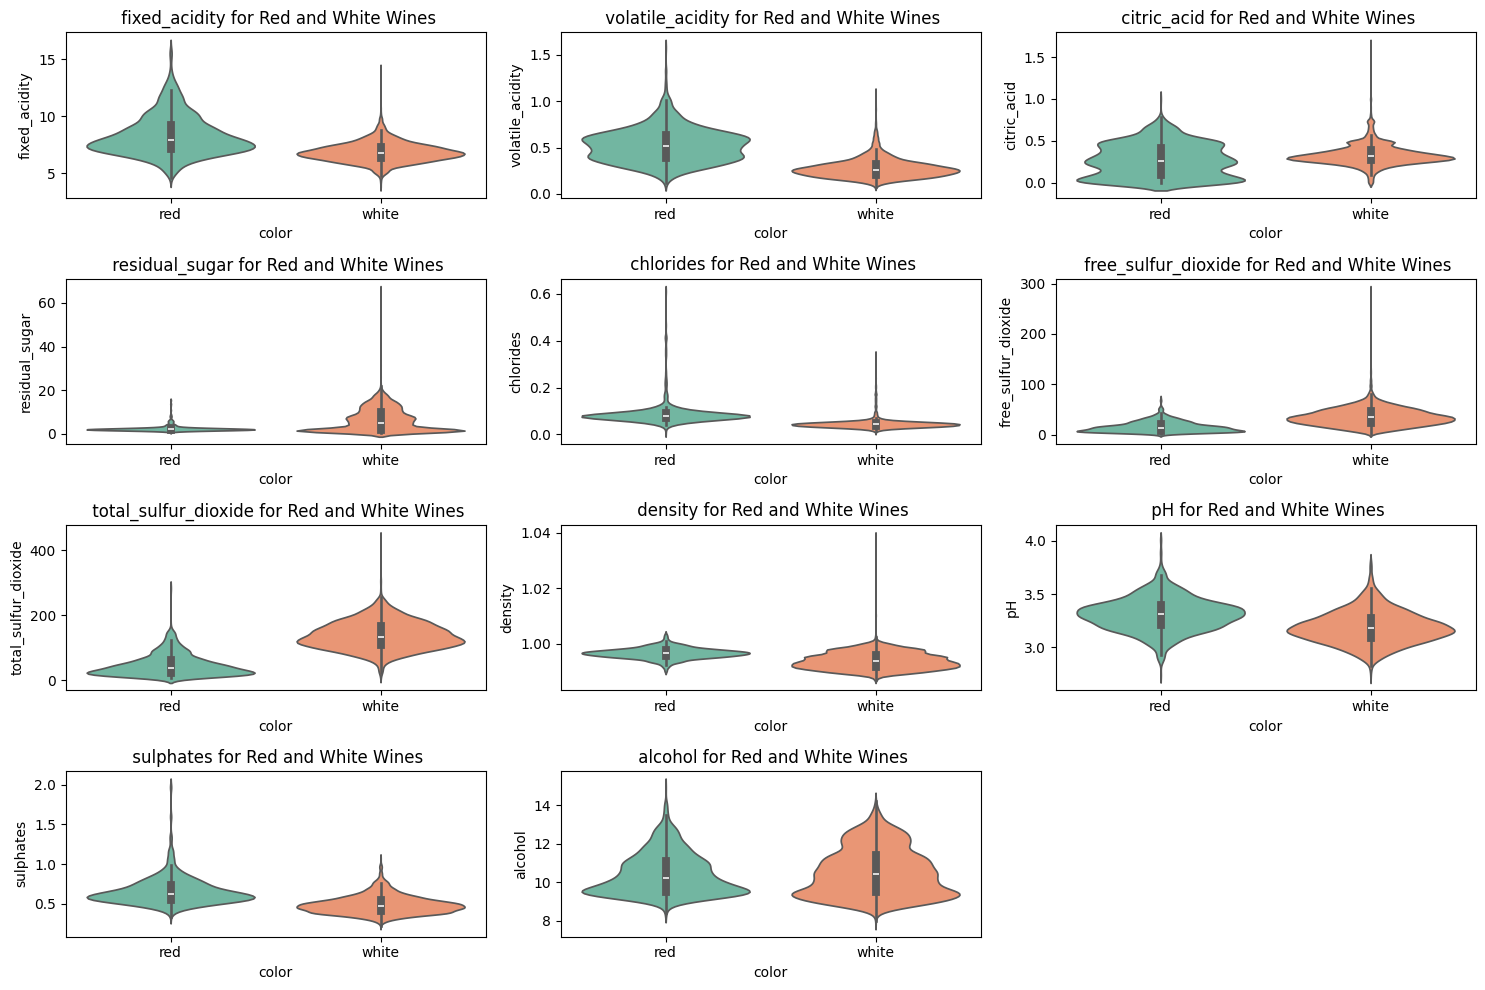

In [247]:
# Set up figure for Violin Plots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 3, i)
    sns.violinplot(x="color", y=feature, data=df, palette="Set2")
    plt.title(f" {feature} for Red and White Wines")
plt.tight_layout()
plt.show()

- Fixed acidity, volatile acidity, and citric acid show a higher range of values for red wines, while white wines have narrower distributions.
- Residual sugar and total sulfur dioxide are significantly higher in white wines, indicating a broader range and more outliers.
- Chlorides, free sulfur dioxide, and alcohol also have wider distributions in white wines, suggesting more variability.
- Most features, like pH and density, show similar medians but different spreads, with some having distinct multimodal shapes (e.g., alcohol).

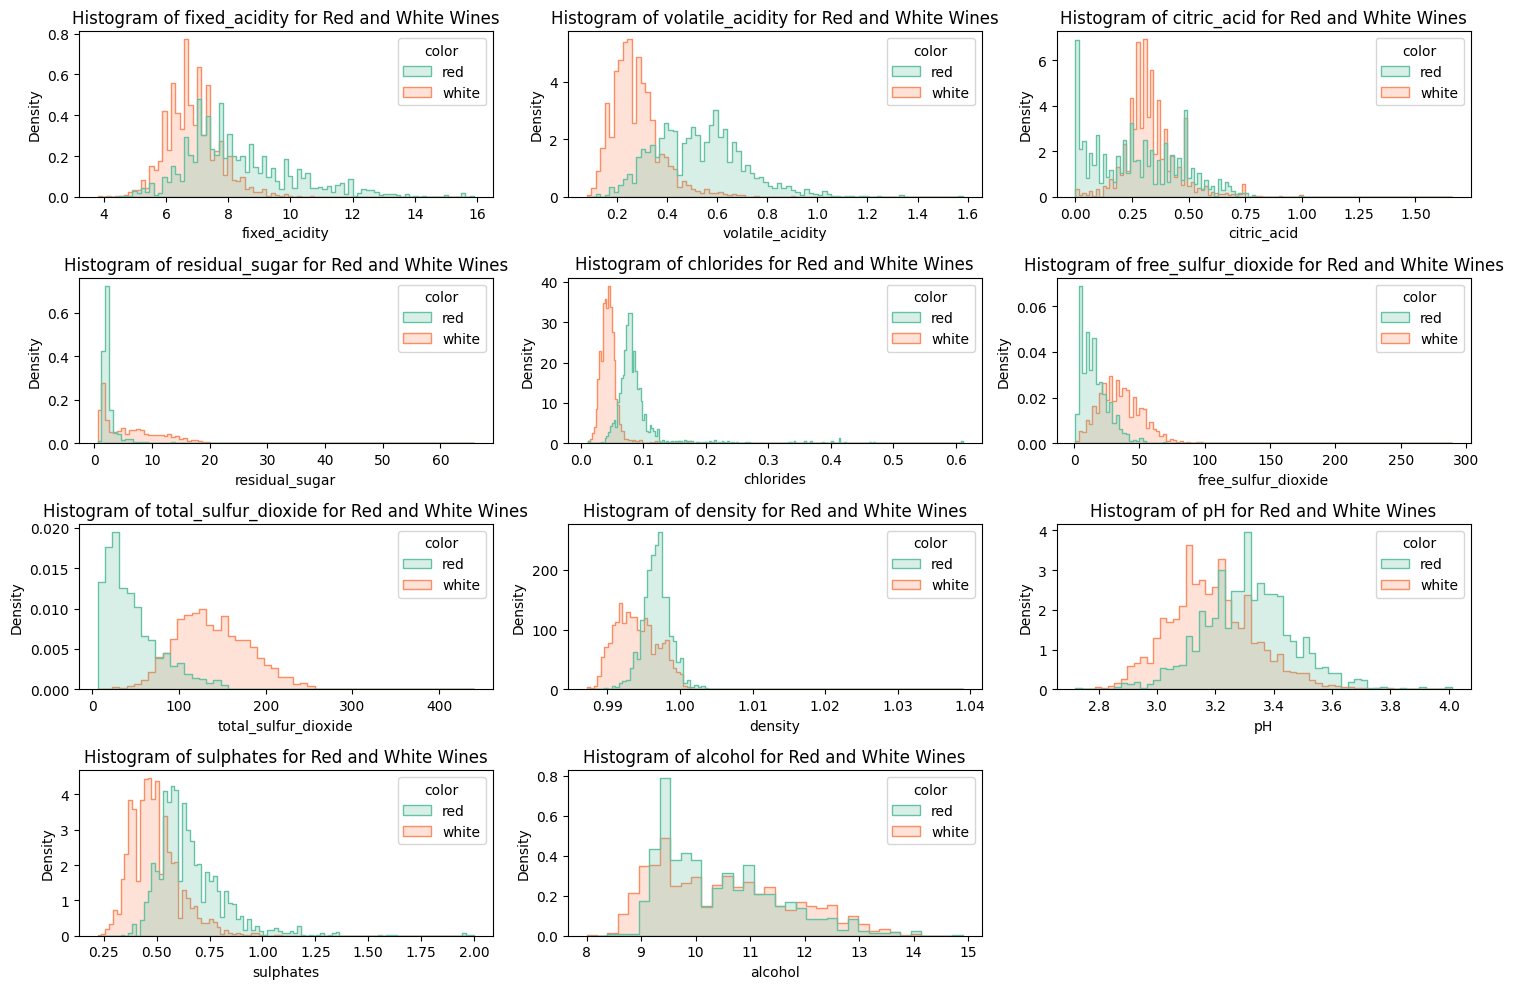

In [248]:
# Set up figure for Histograms
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 3, i)
    sns.histplot(
        data=df,
        x=feature,  # we use multiple feature
        hue="color",  # use to determine the color of plot
        element="step",
        stat="density",
        common_norm=False,
        palette="Set2",
    )
    plt.title(f"Histogram of {feature} for Red and White Wines")
plt.tight_layout()
plt.show()

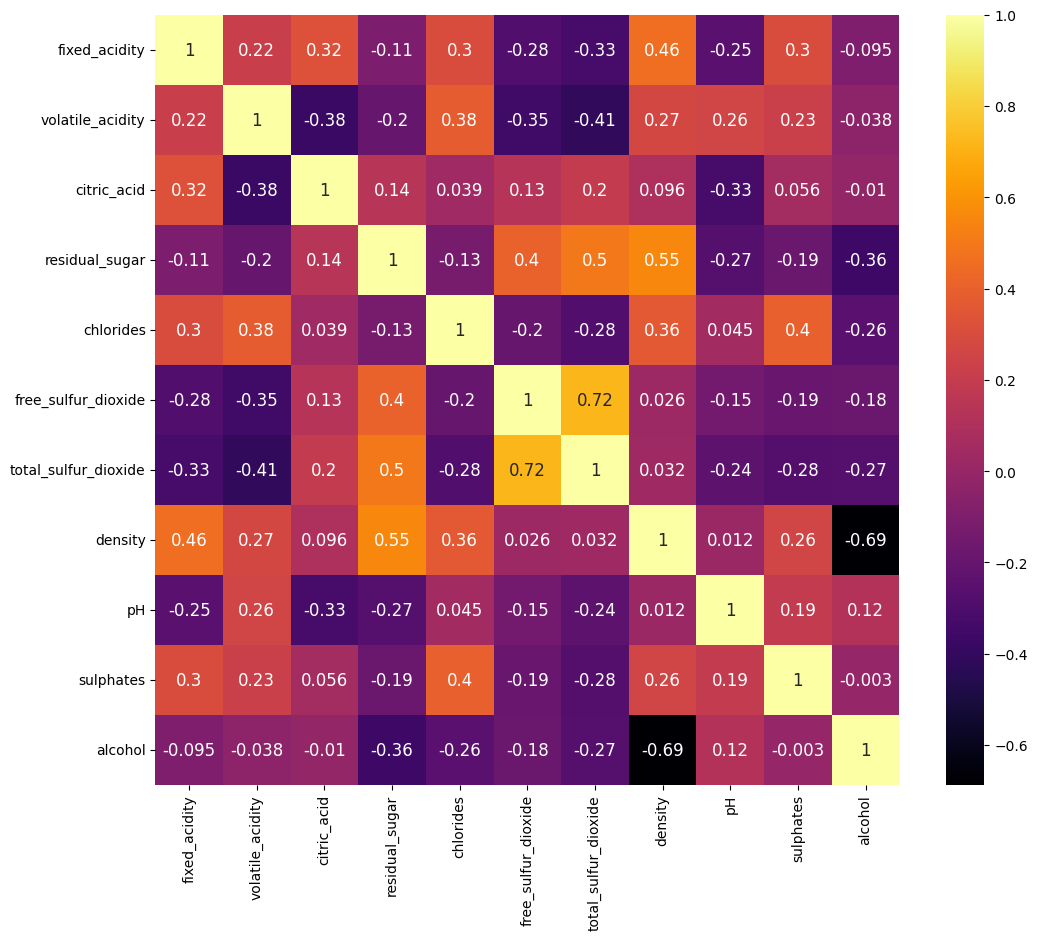

In [249]:
corr_matrix = X.corr()  # Taking without color and score
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="inferno", annot_kws={"size": 12})
plt.show()

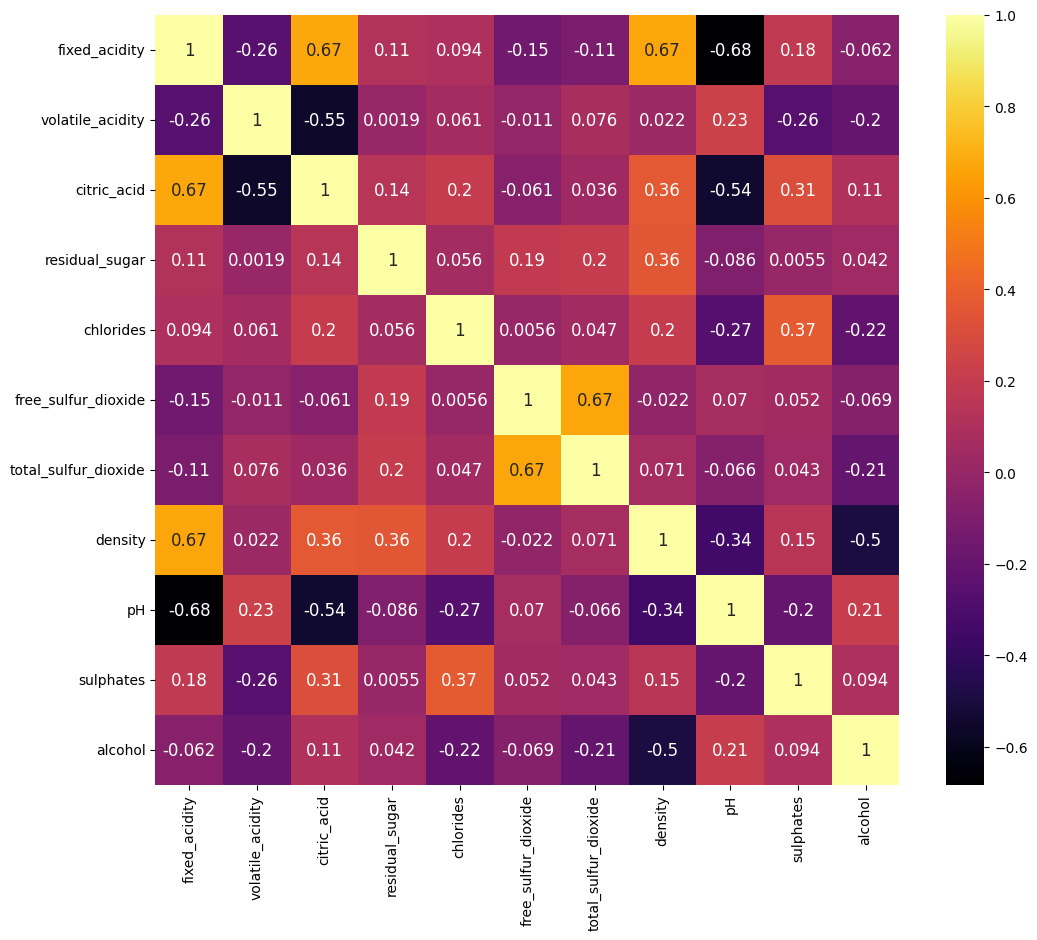

In [250]:
corr_matrix = df_red.drop(
    columns=["color", "quality"]
).corr()  # Taking without color and score
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="inferno", annot_kws={"size": 12})
plt.show()

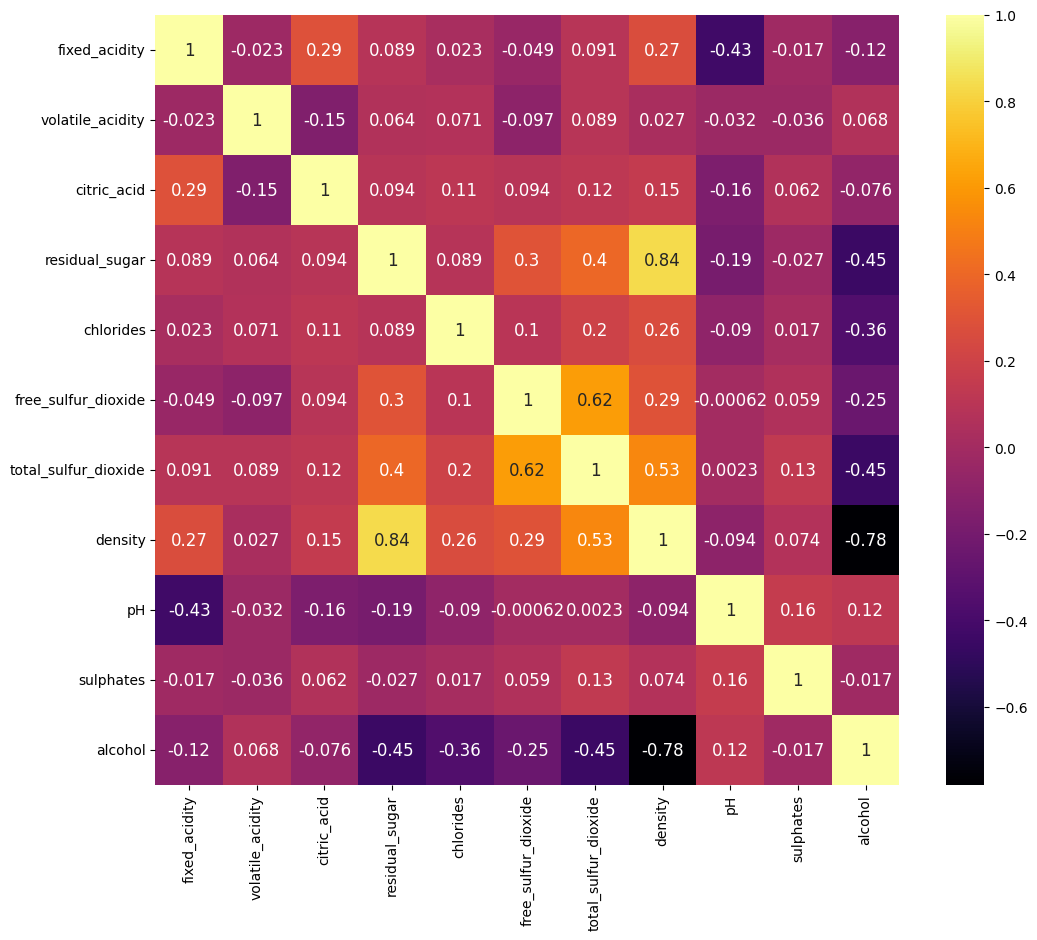

In [251]:
corr_matrix = df_white.drop(
    columns=["color", "quality"]
).corr()  # Taking without color and score
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="inferno", annot_kws={"size": 12})
plt.show()

### Feature correlation with label
Cheking if one of ours features is correlated with the label it can be interesting. Regareding the output, we can see that the volume of alcohol is a little bit correlated with the score! Isn't it interesting?

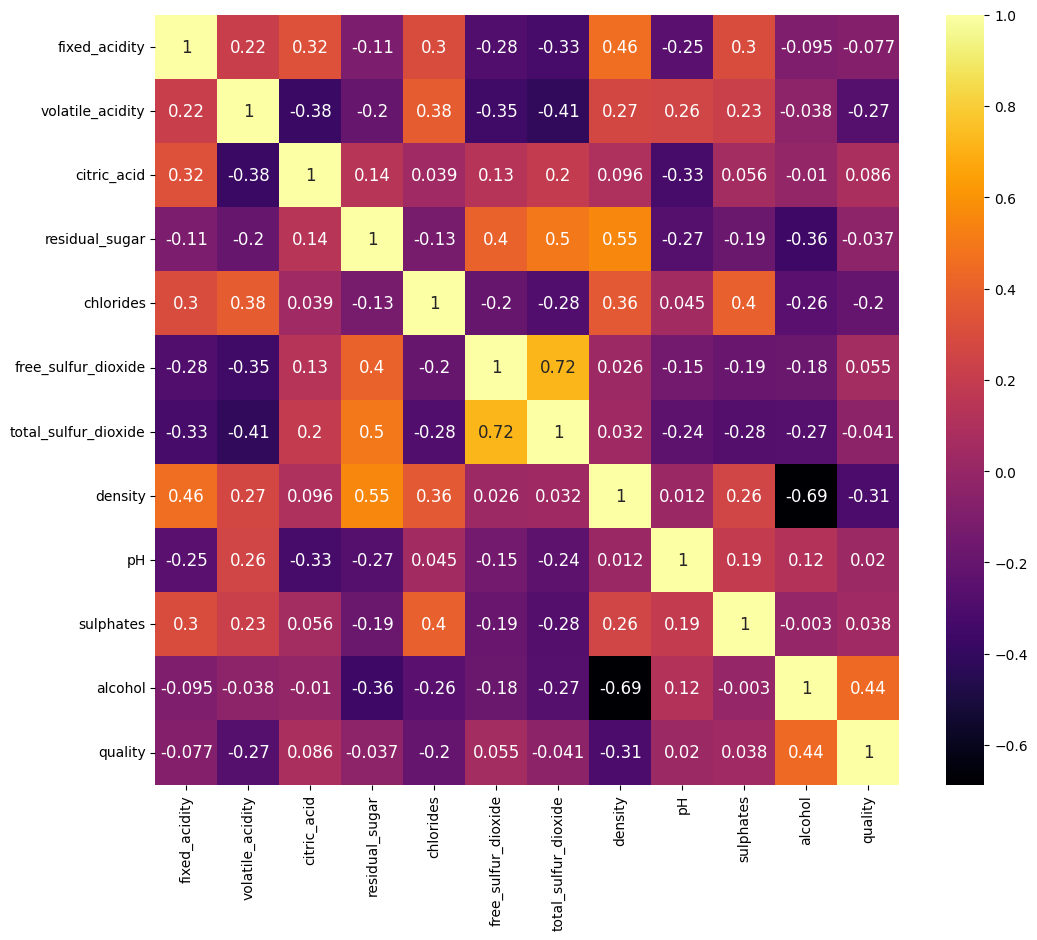

In [252]:
df2 = df[
    [
        "fixed_acidity",
        "volatile_acidity",
        "citric_acid",
        "residual_sugar",
        "chlorides",
        "free_sulfur_dioxide",
        "total_sulfur_dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol",
        "quality",
    ]
]
corr_matrix = df2.corr()  # Taking without color and score
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="inferno", annot_kws={"size": 12})
plt.show()

## Data Exploration using Unsupervised Learning (3h)

We first explore the data in an unsupervised fashion. Start by creating a heatmap of the average feature value for red and white wines. Can you spot an easy way to differentiate between reds and whites?

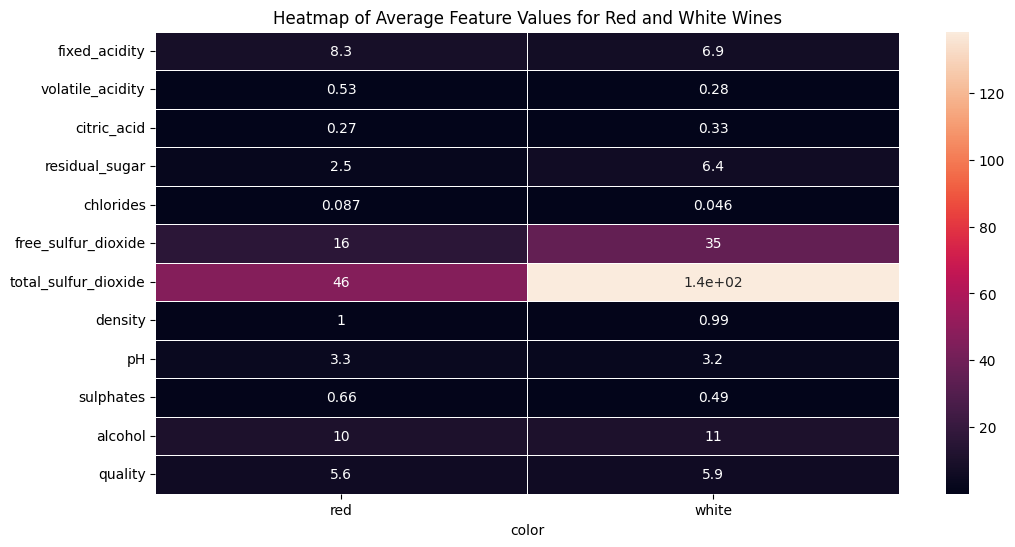

In [253]:
# heatmap
# Calculate the mean values for red and white wines
mean_values = df.groupby("color").mean()

# Create a heatmap of the average feature values
plt.figure(figsize=(12, 6))
sns.heatmap(mean_values.T, annot=True, linewidths=0.5)
plt.title("Heatmap of Average Feature Values for Red and White Wines")
plt.show()

### Using PCA to reduce the dimensionality

Use PCA to reduce the dimensionality of data. Do not forget that it requires data normalization (centering on the mean and scaling to unit variance). Plot the whole dataset onto the two principal components and color it by wine color. What does it tell you?

- We can see that it separates quite well by wine. 

Project the unit vectors that correspond to each vector onto the principal components, using the same transformation. What does it tell you about the relative feature importance? Does it match the observations you made previously? response under the graph

In [254]:
# scale standart scaler to normalize data
scaler = StandardScaler()
df_normalized = scaler.fit_transform(X[numeric_features])

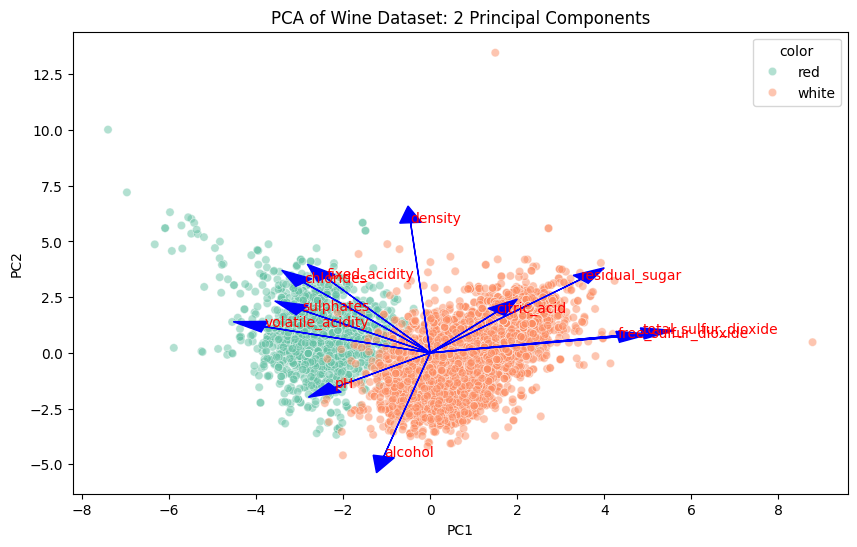

In [255]:
# Project unit vectors (feature importance) onto the principal components
# Stack overflow --> https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis
# Use the components_ attribute from PCA to get the feature importance for each principal component

scaleFactor = 10  # using a scale factor to make it bigger
# Perform PCA and reduce the data to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_normalized)

# Create a new DataFrame to store the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"])
# adding color to the df
pca_df["color"] = df["color"]


# Plot the PCA results, coloring by wine type (red or white)
plt.figure(figsize=(10, 6))

sns.scatterplot(x="PC1", y="PC2", hue="color", data=pca_df, palette="Set2", alpha=0.5)
for i, feature in enumerate(numeric_features):
    plt.arrow(
        0,
        0,
        pca.components_[0, i] * scaleFactor,  # we give the dx
        pca.components_[1, i] * scaleFactor,  # give the dy
        color="blue",
        head_width=0.05 * scaleFactor,
    )
    plt.text(
        pca.components_[0, i] * scaleFactor,
        pca.components_[1, i] * scaleFactor,
        feature,  # just taking the feature
        color="red",  # adding the component name
    )
plt.title("PCA of Wine Dataset: 2 Principal Components")
plt.show()

## analyse 
It helps us to see the features that influence our pca shape, we can see that for white whine citric acid, residual sugar help a lot to shape this PCA

Red whine volatile acidity sulphate.  

For both wines we can see that alcool density give balances to center our PCA

In [256]:
print(pca.transform(np.eye(X.shape[1])))  # USing teacher method

[[-0.2387989   0.33635454]
 [-0.3807575   0.11754972]
 [ 0.15238844  0.1832994 ]
 [ 0.34591993  0.32991418]
 [-0.29011259  0.31525799]
 [ 0.43091401  0.0719326 ]
 [ 0.48741806  0.08726628]
 [-0.04493664  0.58403734]
 [-0.21868644 -0.155869  ]
 [-0.29413517  0.19171577]
 [-0.10643712 -0.46505769]]


### Cluster the data in 2-dimensional space

Use k-means to cluster the data into 2 clusters and plot the same view as before, but with a coloring that corresponds to the cluster memberships.

Assuming that the cluster assignments are predictions of a model, what is the performance you can achieve in terms of mutual information score, accuracy, and f1 score?

In [257]:
kmeans = KMeans(n_clusters=2, random_state=42)
y_kmeans = kmeans.fit_predict(df_normalized)

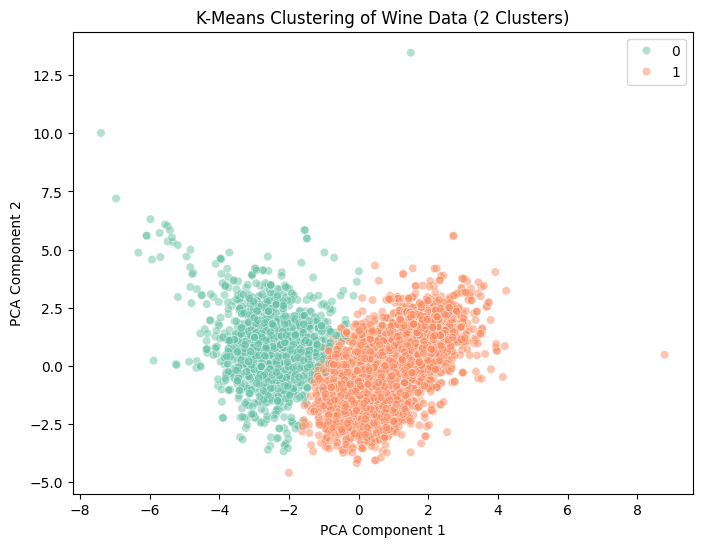

In [258]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue=y_kmeans, data=pca_df, palette="Set2", alpha=0.5)
plt.title("K-Means Clustering of Wine Data (2 Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [259]:
# Mutual Information Score If it's near 0 it tels that th'eyre independant
mi_score = mutual_info_score(df["color"], y_kmeans)
print(f"Mutual Information Score: {mi_score:.4f}")

Mutual Information Score: 0.4911


In [260]:
label_mapping = {"red": 0, "white": 1}
df["color_num"] = df["color"].map(label_mapping)

# Swap y_kmeans labels if accuracy is below 0.5
if accuracy_score(df["color_num"], y_kmeans) < 0.5:
    y_kmeans = 1 - y_kmeans

# Calculate accuracy and F1 score
accuracy = accuracy_score(df["color_num"], y_kmeans)
f1 = f1_score(df["color_num"], y_kmeans, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9858
F1 Score: 0.9859


## Why is it so good

algorithm performed remarkably well in distinguishing red wines from white wines, demonstrating that the chemical composition of the *wines provides a clear separation* between the two types.

Now, we are going to train a **supervised** linear classification model using `sklearn`, and compare the results with the approach using clustering.

- Set up a train/test dataset using `sklearn.model_selection.train_test_split`.
- Use `GridSearchCV` to perform a cross-validation of the model's regularization `C`.
- Compare the test and train performance at the end. Does the model suffer from any overfitting? 
- Analyze the test performance specifically. What can you conclude about this general problem of recognizing white vs red wines?

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, wineColor, test_size=0.25)

In [262]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [263]:
# Grid search to find the best parametres
# Create a parameter grid
param_grid = {
    "logisticregression__C": [0.1, 1, 10, 100],
}

In [264]:
# Fit the model
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy")
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.1, 1, 10, 100]},
             scoring='accuracy')

In [ ]:
from sklearn.model_selection import LearningCurveDisplay


# Plot the learning curve using LearningCurveDisplay
LearningCurveDisplay.from_estimator(
    gs.best_estimator_,
    X_train,
    y_train,
    scoring="accuracy",
    score_name="accuracy",
    line_kw={"marker": "o"},
    n_jobs=-1,
)

In [37]:
best_model = gs.best_estimator_

# Training and test set accuracy
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9938423645320197
Test Accuracy: 0.9963076923076923


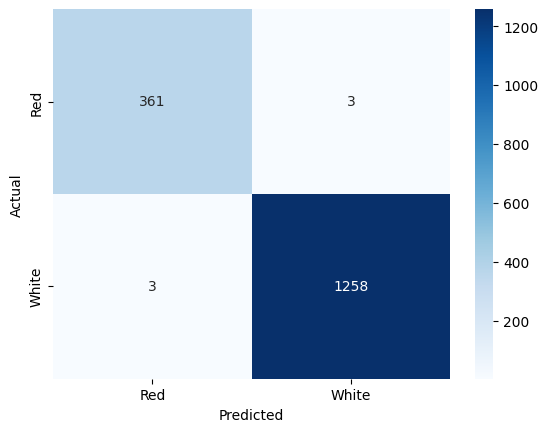

              precision    recall  f1-score   support

         Red       0.99      0.99      0.99       364
       White       1.00      1.00      1.00      1261

    accuracy                           1.00      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       1.00      1.00      1.00      1625



In [38]:
# Predict on the test set
y_pred = best_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Red", "White"],
    yticklabels=["Red", "White"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Red", "White"]))

### Results
High Accuracy on Both Training and Test Sets.
model performs extremely well on this classification task.


### Basic model interpretability: inspecting the model

As a first step towards intepretability of the model predictions, let's take a look at the coefficients of the model. What is the most important feature from this perspective? How do you interpret positive or negative coefficients?

Is it compatible with what you have seen so far? Do you have an explanation why that might be?

In [39]:
log_reg_model = gs.best_estimator_.named_steps["logisticregression"]
# Get the feature names (if using a pandas DataFrame, X.columns would provide them)
feature_names = (
    X.columns if hasattr(X, "columns") else [f"Feature {i}" for i in range(X.shape[1])]
)

# Get the coefficients from the model
coefficients = log_reg_model.coef_[0]

# Combine feature names and their corresponding coefficients
coeffs_with_features = sorted(
    zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True
)

# Print feature importance
print("Feature importance in descending order:")
for feature, coeff in coeffs_with_features:
    print(f"{feature}: {coeff:.4f}")

Feature importance in descending order:
density: -4.7294
residual_sugar: 4.3144
total_sulfur_dioxide: 2.7134
alcohol: -1.9171
free_sulfur_dioxide: -1.0631
volatile_acidity: -1.0136
chlorides: -0.8437
sulphates: -0.4917
fixed_acidity: 0.3207
citric_acid: 0.3174
pH: 0.0870


### Analyse

The higher density and alcohol content in red wines versus the higher sulfur dioxide and residual sugar in white wines are key distinguishing factors.

direction of the coefficients also makes sense based on the chemistry and production processes of different wine types.

### Removing features to test their importance

- What happens if you re-train a model, but remove the most important feature in the list?
- What happens if you re-train the model with a `l1` penalty and you use more regularization? 
- Interpret the results you obtained above from the perspective of the business problem. What does it tell you about the key differences between a red and white wine?

In [40]:
numeric_features

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [41]:
param_grid_stronger_regularization = {
    "logisticregression__C": [0.01, 0.1, 1],
    "logisticregression__penalty": ["l1"],
    "logisticregression__solver": ["liblinear"],
}

In [42]:
features_to_drop = [
    "total_sulfur_dioxide",
    "alcohol",
    "free_sulfur_dioxide",
    "volatile_acidity",
    "fixed_acidity",
]
X_train_reduced = X_train.drop(columns=features_to_drop)
X_test_reduced = X_test.drop(columns=features_to_drop)

In [43]:
X_train_reduced.head()

,citric_acid,residual_sugar,chlorides,density,pH,sulphates
1952,0.40,6.85,0.038,0.99200,3.03,0.30
2371,0.60,1.10,0.135,0.99270,3.12,0.39
2997,0.36,13.10,0.050,0.99860,3.04,0.46
5801,0.31,2.30,0.044,0.99013,3.29,0.46
1613,0.62,19.25,0.040,1.00020,2.98,0.67


In [44]:
X_test_reduced.head()

,citric_acid,residual_sugar,chlorides,density,pH,sulphates
6043,0.25,7.80,0.031,0.99241,3.39,0.40
4627,0.37,6.20,0.050,0.99546,3.20,0.55
2755,0.29,16.85,0.054,0.99980,3.16,0.38
2226,0.24,6.20,0.048,0.99570,3.23,0.62
2553,0.34,9.70,0.035,0.99650,3.08,0.49


In [45]:
y_train.head()

1952    white
2371    white
2997    white
5801    white
1613    white
Name: color, dtype: object

In [46]:
gs_reduced = GridSearchCV(
    estimator=pipe, param_grid=param_grid_stronger_regularization, scoring="accuracy"
)
gs_reduced.fit(X_train_reduced, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1],
                         'logisticregression__penalty': ['l1'],
                         'logisticregression__solver': ['liblinear']},
             scoring='accuracy')

In [47]:
# Accuracy
train_accuracy_reduced = gs_reduced.best_estimator_.score(X_train_reduced, y_train)
test_accuracy_reduced = gs_reduced.best_estimator_.score(X_test_reduced, y_test)

In [48]:
print(f"Training Accuracy (without density): {train_accuracy_reduced}")
print(f"Test Accuracy (without density): {test_accuracy_reduced}")

Training Accuracy (without density): 0.9630541871921182
Test Accuracy (without density): 0.9624615384615385


### Using Shapley values

Now, use SHAP to explore how the model perceives a 'red' and 'white' wine.

- Use a `beeswarm` plot to analyze the influence of each feature on the model's output.
- What does the plot tell us about what makes a white wine 'white' and a red wine 'red'?

In [49]:
label_mapping = {"red": 0, "white": 1}
y_train = y_train.map(label_mapping)

In [50]:
y_train.head()

1952    1
2371    1
2997    1
5801    1
1613    1
Name: color, dtype: int64

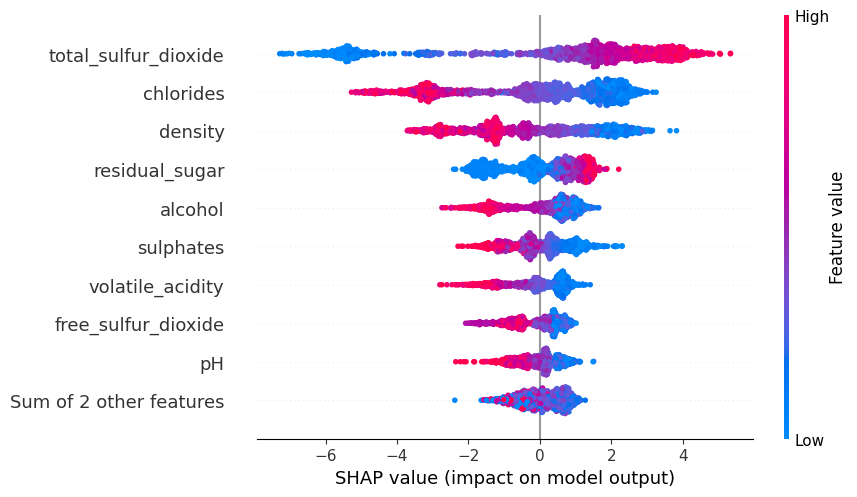

In [51]:
# Train the XGBoost classifier
model = xgb.XGBClassifier().fit(X_train, y_train)

# Create the SHAP explainer
explainer = shap.Explainer(model, X_test)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Generate a beeswarm plot to visualize feature impact
shap.plots.beeswarm(shap_values)

### Analyse

Features such as sulfur dioxide, chlorides, residual sugar, alcohol content, and acidity are critical in determining whether the wine is red or white

White wines are associated with higher sulfur dioxide, chlorides, residual sugar, and density, while red wines are linked to higher volatile acidity, alcohol, and fixed acidity. 

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.

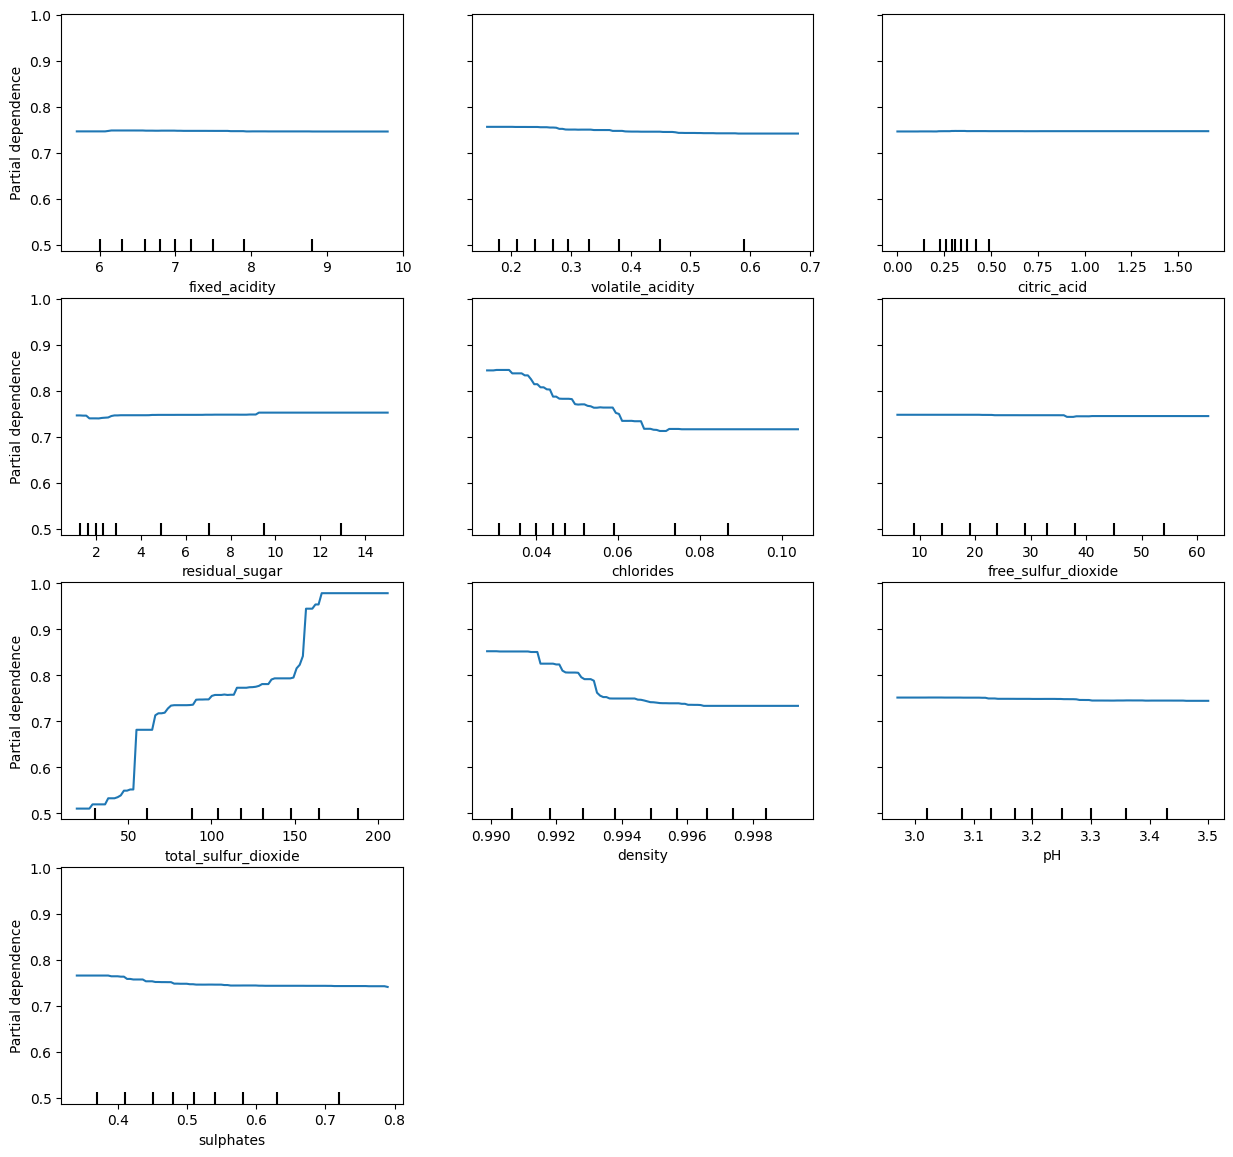

In [52]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = list(range(X_train.shape[1] - 1))
fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(model, X_train, features, ax=ax)

plt.subplots_adjust(top=1.2)
plt.show()

### Anylse

Total Sulfur Dioxide: Higher levels of total sulfur dioxide strongly increase the model's predictions.

Density: Lower-density wines tend to decrease the prediction, while higher-density wines positively influence the model up to a threshold

Residual Sugar: Higher residual sugar levels significantly increase the model's output, suggesting that sweeter wines are more likely to be classified or scored higher

- Now use a waterfall diagram on a specific red and white wine and see how the model has made this specific prediction. 

Waterfall plot for red wine:


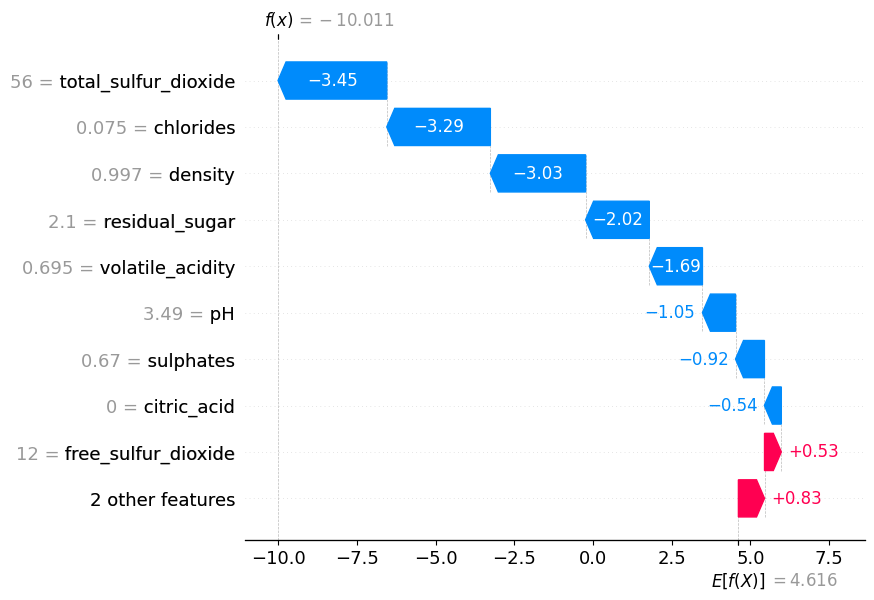

Waterfall plot for white wine:


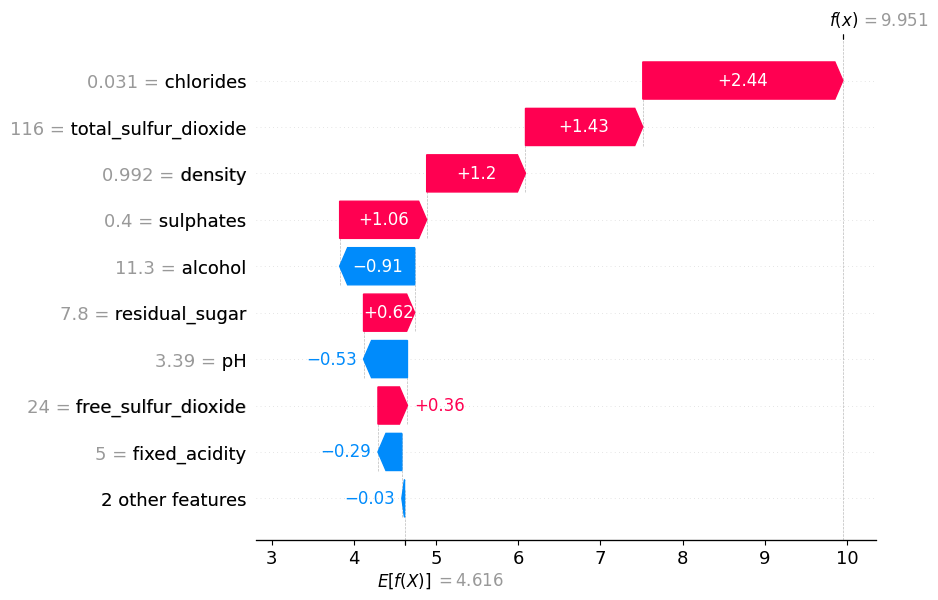

In [53]:
# Find the index of the first red wine and white wine in the test set
red_wine_index = list(y_test).index("red")
white_wine_index = list(y_test).index("white")

# Calculate SHAP values for these specific instances
shap_values_red = explainer(X_test[red_wine_index : red_wine_index + 1])
shap_values_white = explainer(X_test[white_wine_index : white_wine_index + 1])

# Step 4: Waterfall plot for red wine
print("Waterfall plot for red wine:")
shap.plots.waterfall(shap_values_red[0])

# Step 5: Waterfall plot for white wine
print("Waterfall plot for white wine:")
shap.plots.waterfall(shap_values_white[0])

### Analyse

For the red wine a lower-quality score, with high levels of sulfur dioxide, chlorides, and density negatively impacting the prediction, positive effects from alcohol and free sulfur dioxide

For the white wine a higher quality, driven by positive contributions from chlorides, sulfur dioxide, and density, with slight negative impacts from alcohol and free sulfur dioxide

- Now, let's take an example where the model has made an incorrect prediction, and see how it made this prediction.

/tmp/ipykernel_148848/1797406096.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_numeric = y_test.replace({"red": 0, "white": 1})


Number of incorrect predictions: 5
Actual label: 1
Predicted label: 0
Waterfall plot for the incorrect prediction:


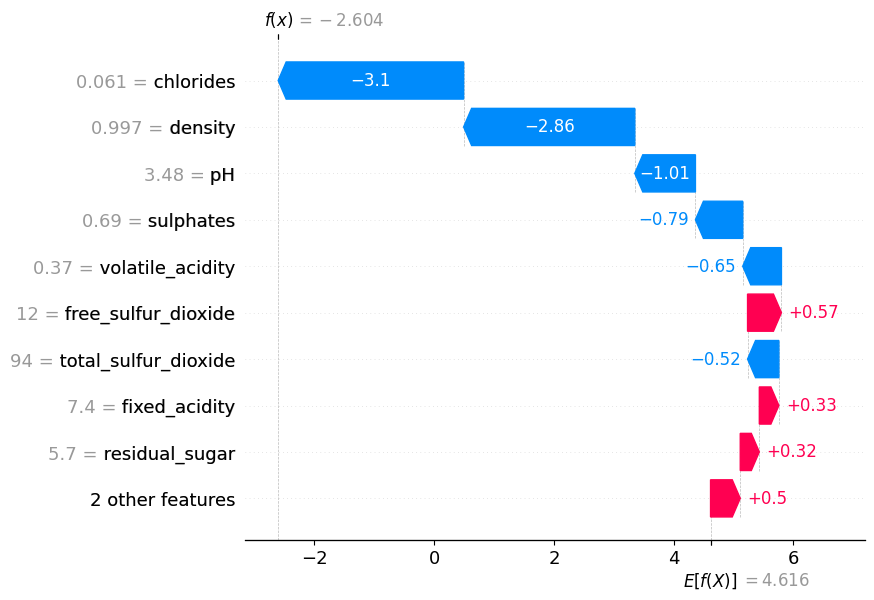

In [54]:
# Get model predictions on the test set
predictions = model.predict(X_test)

# Convert 'red' and 'white' labels to 0 and 1 in y_test
y_test_numeric = y_test.replace({"red": 0, "white": 1})

# Identify incorrect predictions
incorrect_indices = np.where(predictions != y_test_numeric)[0]

# Check if there are any incorrect predictions
if len(incorrect_indices) > 0:
    print(f"Number of incorrect predictions: {len(incorrect_indices)}")

    # Choose the first incorrect prediction
    incorrect_index = incorrect_indices[0]

    # Print the actual and predicted label
    print(f"Actual label: {y_test_numeric.iloc[incorrect_index]}")  # Now numeric labels
    print(f"Predicted label: {predictions[incorrect_index]}")

    # Calculate SHAP values for the incorrect prediction
    shap_values_incorrect = explainer(X_test[incorrect_index : incorrect_index + 1])

    # Waterfall plot to explain the incorrect prediction
    print("Waterfall plot for the incorrect prediction:")
    shap.plots.waterfall(shap_values_incorrect[0])

else:
    print("No incorrect predictions found.")

### Analyse

high sulfur dioxide levels strongly influenced the model towards predicting a higher quality score than expected.

Alcohol has a large negative effect

residual sugar and density contributed positively

# Good vs Bad classification (3h)

We are going to work on a binary classification problem, where all wines with a quality higher than 6 are considered as "good" and other are considered as "bad".  

- Prepare a dataset with a new column `binary_quality` that corresponds to the above definition.

In [55]:
# Create 'binary_quality' column
df["binary_quality"] = df["quality"].apply(lambda x: 1 if x > 6 else 0)
df["color_label"] = df["color"].map({"red": 0, "white": 1})

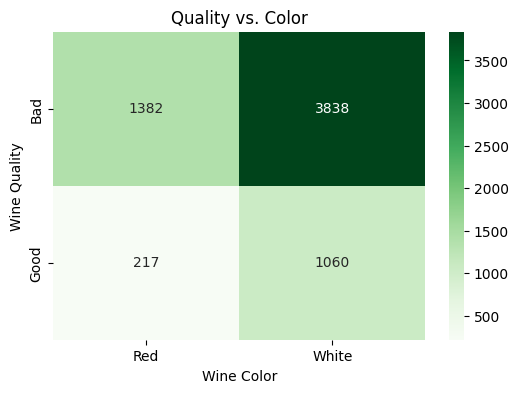

In [56]:
# Confusion matrix between quality and color
cm_quality_color = confusion_matrix(df["binary_quality"], df["color_label"])
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_quality_color,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Red", "White"],
    yticklabels=["Bad", "Good"],
)
plt.xlabel("Wine Color")
plt.ylabel("Wine Quality")
plt.title("Quality vs. Color")
plt.show()

One question that we might ask right away is:

- Is there any correlation of the quality and the color of the wine? 

Ideally, there should be almost none. Why could it be a problem otherwise?

*Answer* :   wine quality should not be correlated with color because quality is expected.
This imbalance between white and red wines, especially in the "bad" category, could impact your model's performance or cause bias if not accounted for.

If it turns out that there are significantly more bad red wines than bad white wines or vice versa, what are the implications for your analysis?

- Plot a heatmap of the mean feature value for bad and good wines, like we did before for red and white wines.
- Plot two heatmaps, one for red and white wines. How do they differ? What kind of issue can it cause?



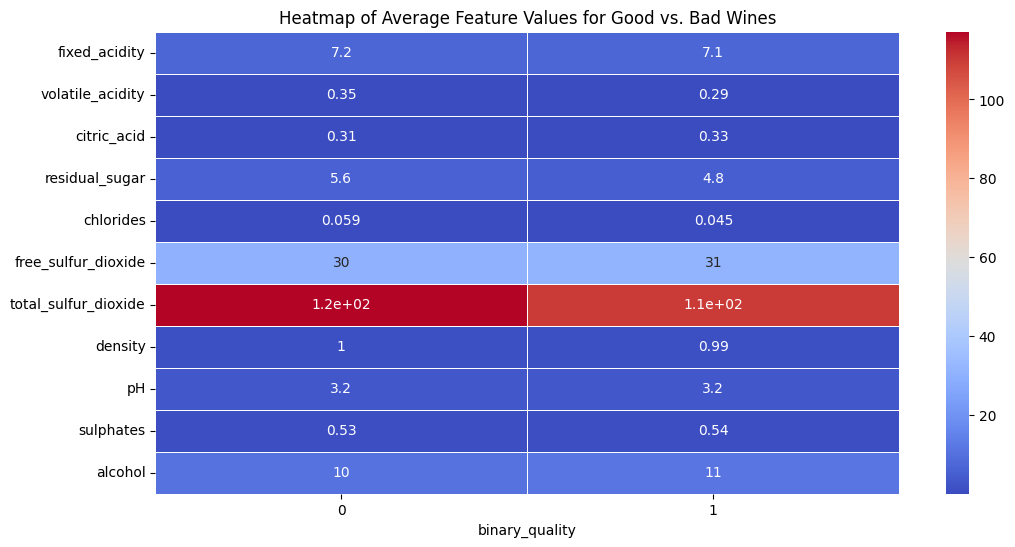

In [57]:
# Create a heatmap for mean feature values of bad and good wines
good_bad_mean_values = df.groupby("binary_quality")[numeric_features].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(good_bad_mean_values.T, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Average Feature Values for Good vs. Bad Wines")
plt.show()

### Aalyse Good vs bad

Good wines have higher levels of alcohol, residual sugar, and free sulfur dioxide.

Bad wines, on the other hand, have higher levels of volatile acidity, fixed acidity, and total sulfur dioxide.

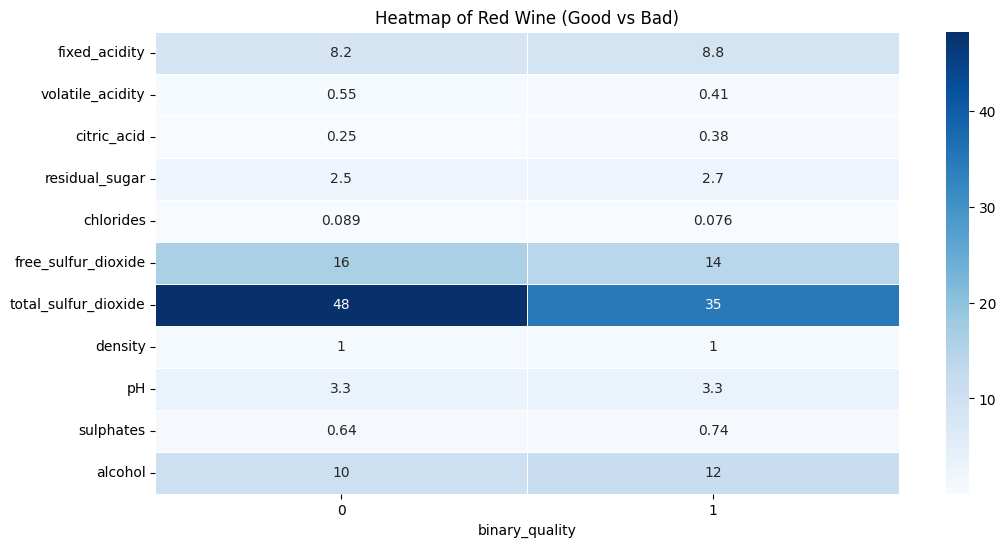

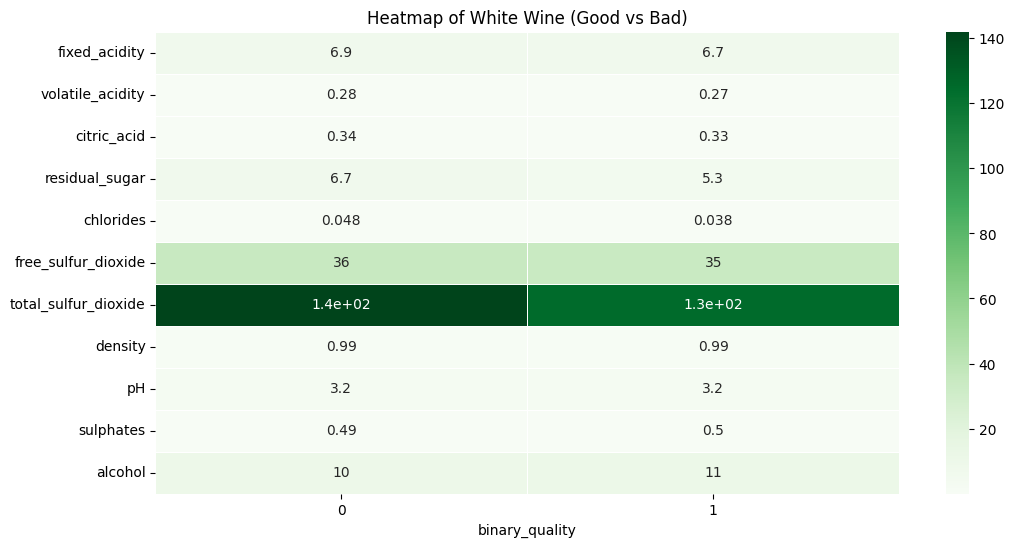

In [58]:
# Separate red and white wines
df_red = df[df["color_label"] == 0]  # Red wines
df_white = df[df["color_label"] == 1]  # White wines

# Heatmap for red wines
red_good_bad_mean_values = df_red.groupby("binary_quality")[numeric_features].mean()
plt.figure(figsize=(12, 6))
sns.heatmap(red_good_bad_mean_values.T, annot=True, cmap="Blues", linewidths=0.5)
plt.title("Heatmap of Red Wine (Good vs Bad)")
plt.show()

# Heatmap for white wines
white_good_bad_mean_values = df_white.groupby("binary_quality")[numeric_features].mean()
plt.figure(figsize=(12, 6))
sns.heatmap(white_good_bad_mean_values.T, annot=True, cmap="Greens", linewidths=0.5)
plt.title("Heatmap of White Wine (Good vs Bad)")
plt.show()

### Analyse white and red good wines

Good red wines show slightly higher levels of alcohol and fixed acidity, while total sulfur dioxide and free sulfur dioxide are generally lower compared to bad wines

Good white wines feature lower total sulfur dioxide levels compared to bad wines, but the difference is less stark than in red wines

It is a lot more difficult now to tell apart good from bad wines. Let's turn to a more complex model, which is a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) [Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). For the sake of interpretability, design your notebook so that you can easily filter on only white and red wines and perform again the entire procedure.

Let's first train a XGBClassifier model to distinguish between good and bad wines. Make sure to use the same best-practices (train/test split, cross-validation) as we did before. Note that the regularization of the GBTs is a lot more complex than for Logistic Regression. Test the following parameters:

  ```py
  param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
  ```

In [59]:
features = df[numeric_features + ["color_label"]]
target = df["binary_quality"]

# Split data
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(
    features, target, test_size=0.25, random_state=42
)

In [60]:
# Model and grid search
model_xgb_q = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
grid_search_q = GridSearchCV(
    model_xgb_q, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
)
grid_search_q.fit(X_train_q, y_train_q)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:15:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:15:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:15:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:15:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encod

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1, param_grid={'logisticregression__C': [0.1, 1, 10, 100]},
             scoring='accuracy', verbose=1)

In [61]:
print("Best Parameters:", grid_search_q.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_q.best_score_)

# Evaluate on test set
y_pred_q = grid_search_q.predict(X_test_q)
test_accuracy_q = accuracy_score(y_test_q, y_pred_q)
print(f"Test Accuracy: {test_accuracy_q:.4f}")

Best Parameters: {'logisticregression__C': 0.1}
Best Cross-Validation Accuracy: 0.8641223608697942
Test Accuracy: 0.8825


- Analyze the results (test and train), validate whether there is overfitting.

In [62]:
# Training accuracy
train_accuracy_q = grid_search_q.score(X_train_q, y_train_q)
print(f"Training Accuracy: {train_accuracy_q:.4f}")

# Compare training and test accuracy
print(f"Training Accuracy: {train_accuracy_q:.4f}")
print(f"Test Accuracy: {test_accuracy_q:.4f}")

Training Accuracy: 0.9977
Training Accuracy: 0.9977
Test Accuracy: 0.8825


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1322
           1       0.72      0.60      0.65       303

    accuracy                           0.88      1625
   macro avg       0.82      0.77      0.79      1625
weighted avg       0.88      0.88      0.88      1625



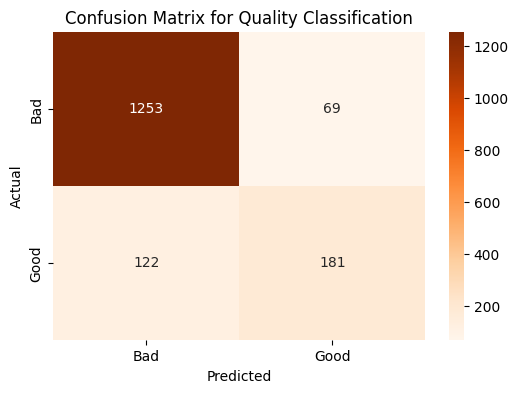

In [63]:
print("Classification Report:")
print(classification_report(y_test_q, y_pred_q))

# Confusion matrix
cm_q = confusion_matrix(y_test_q, y_pred_q)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_q,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=["Bad", "Good"],
    yticklabels=["Bad", "Good"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Quality Classification")
plt.show()

/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:10:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encod

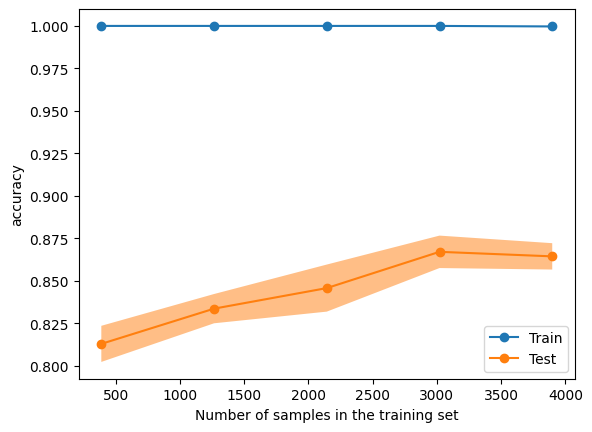

In [229]:
# Plot the learning curve using LearningCurveDisplay
LearningCurveDisplay.from_estimator(
    grid_search_q.best_estimator_,
    X_train_q,
    y_train_q,
    scoring="accuracy",
    score_name="accuracy",
    line_kw={"marker": "o"},
    n_jobs=-1,
)

## Interpretability with SHAP (2h)

- Plot the feature importance (gain and cover) from the XGBoost model. What can you conclude?

### Analyse

Overfitting, as the model performs much better on the training data than on unseen test data. But the gap is that the training accuracy is 0.99 while the test is 0.88

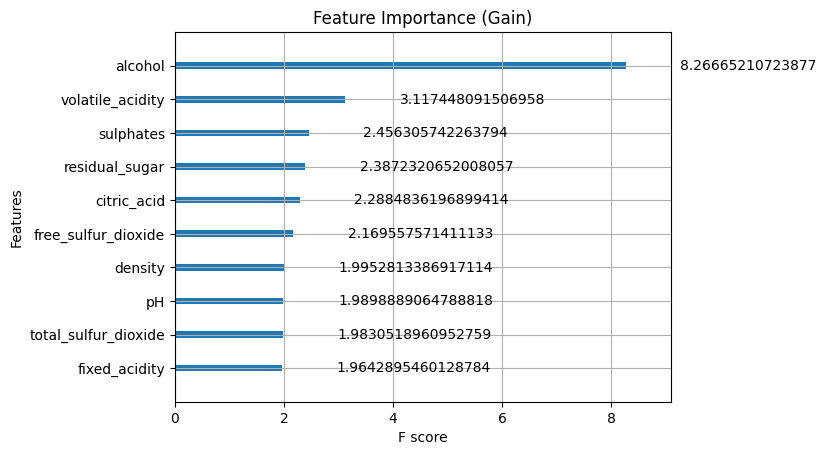

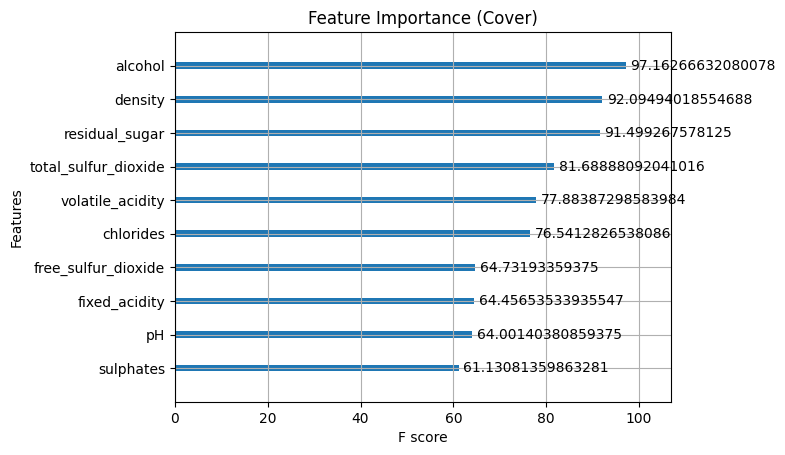

In [64]:
# Idea from https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

# Retrieve feature importance (gain, cover)
importance_gain = grid_search_q.best_estimator_.get_booster().get_score(
    importance_type="gain"
)
importance_cover = grid_search_q.best_estimator_.get_booster().get_score(
    importance_type="cover"
)

# Plot the feature importance based on gain
xgb.plot_importance(
    grid_search_q.best_estimator_,
    importance_type="gain",
    max_num_features=10,
    title="Feature Importance (Gain)",
)
plt.show()

# Plot the feature importance based on cover
xgb.plot_importance(
    grid_search_q.best_estimator_,
    importance_type="cover",
    max_num_features=10,
    title="Feature Importance (Cover)",
)
plt.show()

Volatile_acidity and sulphates follow, but their contributions are much smaller. This suggests that alcohol plays a crucial role in the model's predictive power, while other features like fixed_acidity and total_sulfur_dioxide contribute less.

alcohol, density, and residual_sugar affect a larger portion of the data, while features like sulphates and pH are less commonly used.

Gain: measures the improvement in accuracy or reduction in the loss function brought by a feature. Gain focuses on the quality of a feature's contribution

Cover: measures the number of observations affected by a feature


https://link.springer.com/article/10.1134/S1061934823120171

https://www.sciencehistory.org/stories/magazine/scientia-vitis-decanting-the-chemistry-of-wine-flavor/

https://www.mdpi.com/2306-5710/8/1/1  

- Use SHAP's `TreeExplainer` to compute feature importance (Shapley values). Do you see any difference with XGBoost's feature importances?
- Produce different plots to analyze Shapley values: 
  - A bar plot that summarizes the mean absolute value of each feature.
  - A beeswarm plot that shows the shapley value for every sample and every feature.
  - A [heatmap plot](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) that indicates how different feature patterns influence the model's output.
- Based on the above results, what makes a wine 'good' or 'bad'?

* Following tutorial *


https://medium.com/@emilykmarsh/xgboost-feature-importance-233ee27c33a4

In [74]:
shap_object = explainer(X_train_q)

In [65]:
# Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(grid_search_q.best_estimator_)

In [66]:
shap_values = explainer.shap_values(X_train_q)

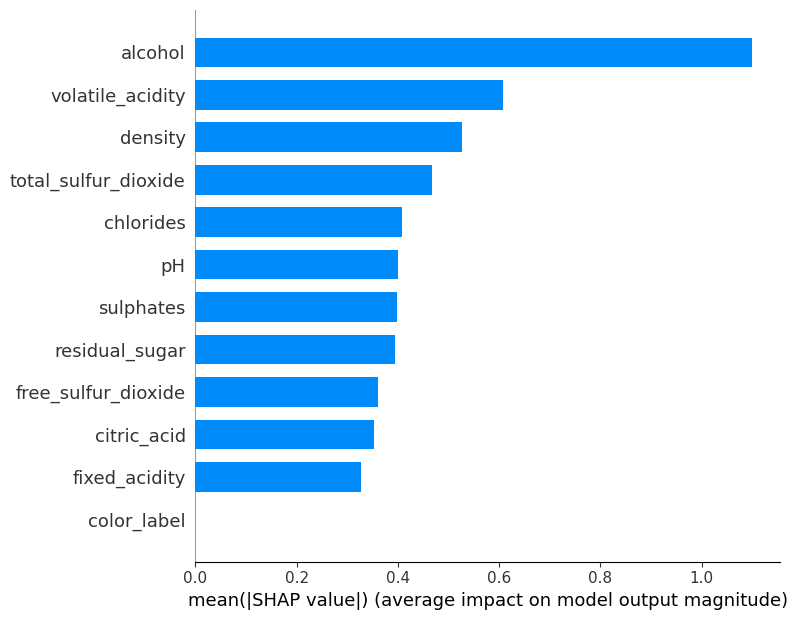

In [67]:
shap.summary_plot(shap_values, X_train_q, plot_type="bar")

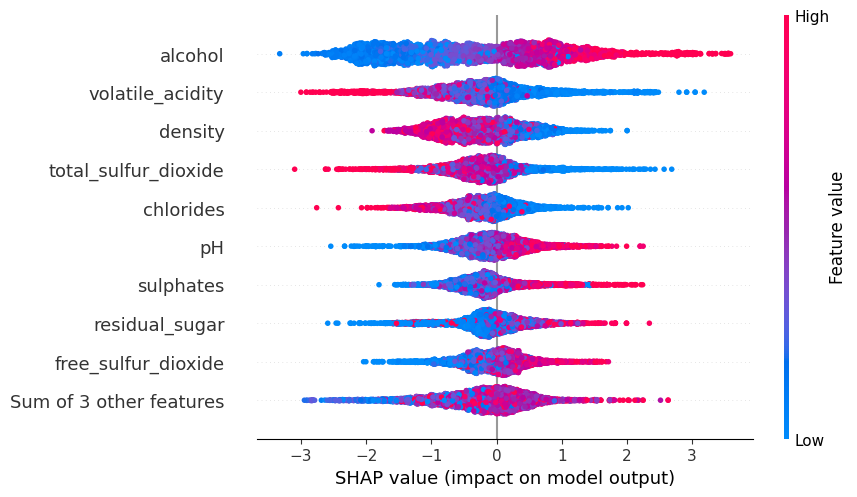

In [75]:
shap.plots.beeswarm(shap_object)

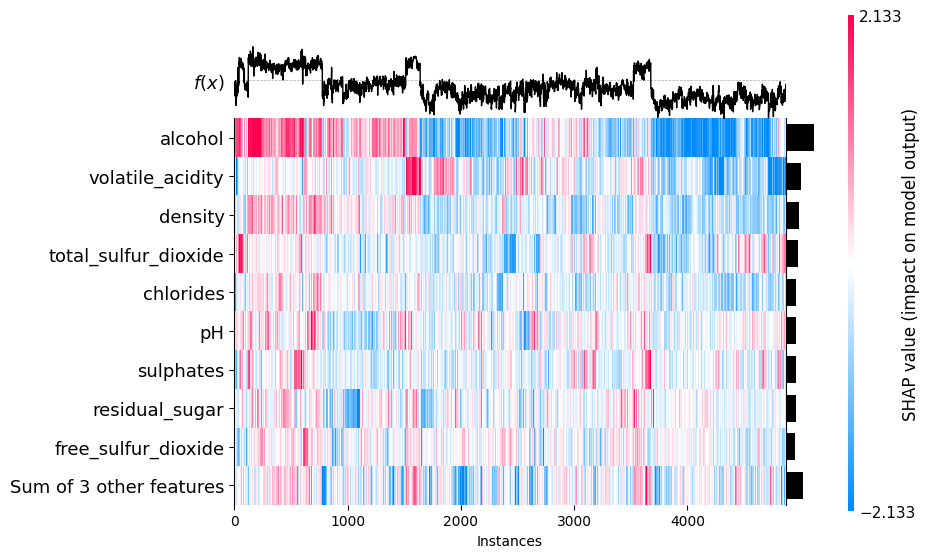

<Axes: xlabel='Instances'>

In [76]:
shap.plots.heatmap(shap_object)

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.
- How does that modify your perspective on what makes a good or bad wine?

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:34:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:34:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:34:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/franciscoribeiro/Work/ML/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:34:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "logisticregression__C", "use_label_encod

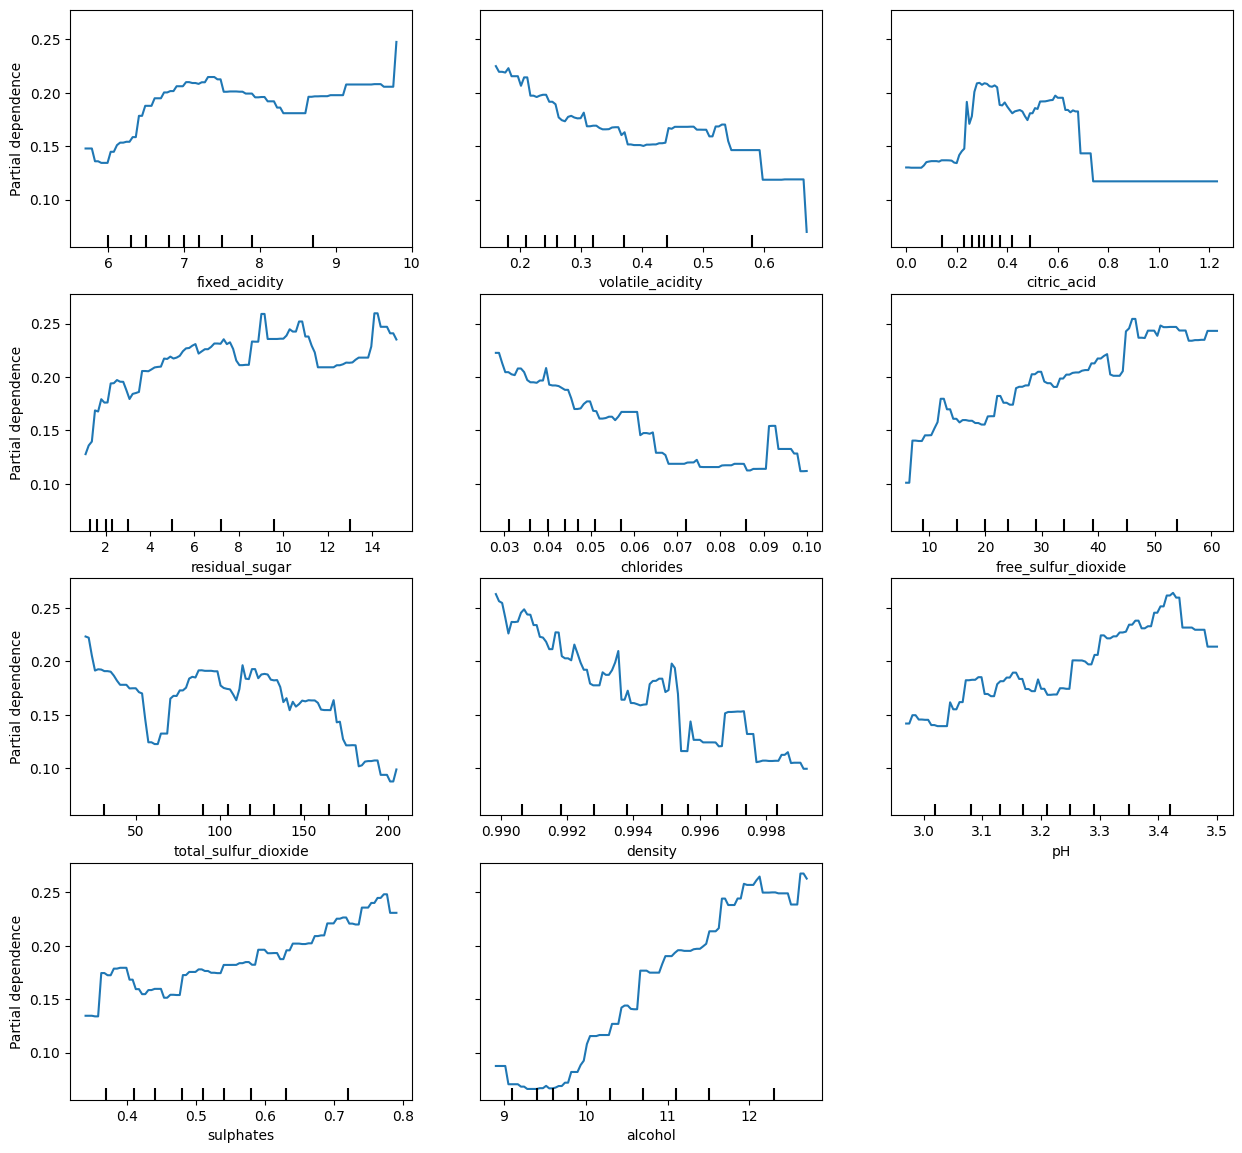

In [84]:
# Train the_ model with the filtered data
grid_search_q.fit(X_train_q, y_train_q)

# Generate Partial Dependence Plot
features = list(range(X_train.shape[1]))
fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(
    grid_search_q.best_estimator_, X_train_q, features, ax=ax
)

plt.subplots_adjust(top=1.2)
plt.show()

- Search for literature or resources that provide indications of the chemical structure of good or poor wines. Do your findings match these resources? 

Alcohol: Higher alcohol content generally correlates with better quality, especially in red wines​

Volatile Acidity: High levels are undesirable, as they can give the wine a vinegar-like taste, reducing quality​(
Science History Institute

Total Sulfur Dioxide: High levels preserve the wine but can negatively affect taste if excessive, especially in white wines​

Residual Sugar: Affects sweetness; balanced levels enhance wine quality, but too much can make the wine taste overly sweet​
pH and Acidity: Lower pH (higher acidity) enhances the freshness of the wine, but must be balanced to avoid excessive tartness​

Tannins: Provide structure and astringency, especially in red wines; over-extraction leads to bitterness, reducing quality​.

### Analyze a few bad wines, and try to see how to make them better

Pick some of the worst wines, and try to see what make them so bad. Check out [`shap.plots.heatmap`](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) for some visual tool to do this.

How would you go about improving them?

 ### Lets analyse 

In [156]:
worst_wines = X_train_q[y_train_q == 0]
worst_wines_quality = y_train_q[y_train_q == 0]
# take 10 randomly
random_worst_wines = worst_wines.sample(n=800, random_state=42)
random_worst_wines_quality = worst_wines_quality.loc[random_worst_wines.index]

In [157]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(grid_search_q.best_estimator_)

# Compute SHAP values for the worst wines
shap_values_worst = explainer.shap_values(random_worst_wines)

# Wrap into a SHAP explanation object
shap_values_worst_expl = shap.Explanation(
    shap_values_worst,
    base_values=explainer.expected_value,
    data=random_worst_wines,
    feature_names=worst_wines.columns,
)

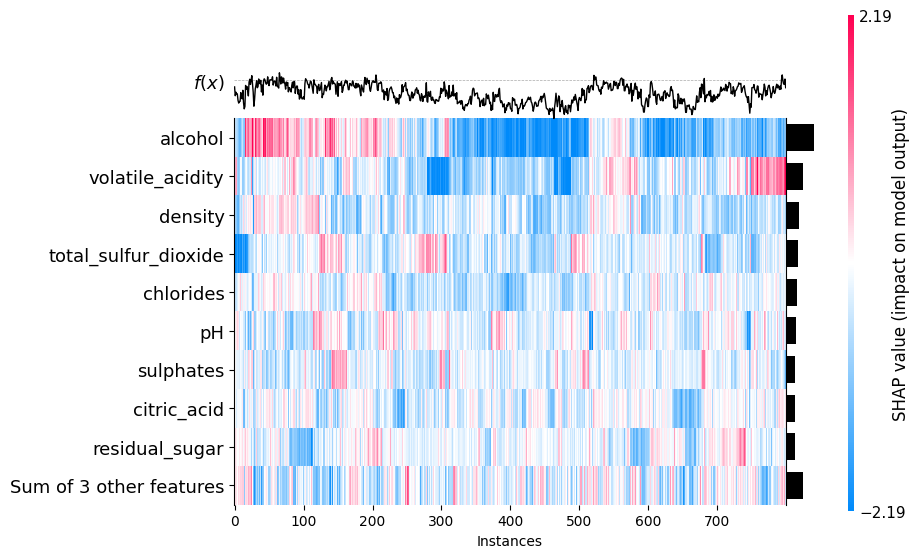

<Axes: xlabel='Instances'>

In [158]:
# Create a SHAP heatmap plot for the worst wines
shap.plots.heatmap(shap_values_worst_expl)

low alcohol content and high volatile acidity are major factors negatively affecting wine quality. Density also contributes negatively for most wines, suggesting an imbalance. Total sulfur dioxide and pH have mixed effects, indicating they need to be optimized for each wine. Increasing alcohol and sulphates, while reducing volatile acidity and density, could improve these wines. Focusing on balancing these key features should lead to higher quality.

In [101]:
X_train_q

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color_label
1539,7.2,0.390,0.32,1.80,0.065,34.0,60.0,0.99714,3.46,0.78,9.9,0
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,0
100,8.3,0.610,0.30,2.10,0.084,11.0,50.0,0.99720,3.40,0.61,10.2,0
5477,6.5,0.350,0.31,10.20,0.069,58.0,170.0,0.99692,3.18,0.49,9.4,1
6416,5.8,0.385,0.25,3.70,0.031,38.0,122.0,0.99128,3.20,0.63,11.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3772,7.6,0.320,0.58,16.75,0.050,43.0,163.0,0.99990,3.15,0.54,9.2,1
5191,5.6,0.280,0.27,3.90,0.043,52.0,158.0,0.99202,3.35,0.44,10.7,1
5226,6.4,0.370,0.20,5.60,0.117,61.0,183.0,0.99459,3.24,0.43,9.5,1
5390,6.5,0.260,0.50,8.00,0.051,46.0,197.0,0.99536,3.18,0.47,9.5,1


In [220]:
color = 0  ## use 0 when red 1 when white
random_or_all = False  # takes random n+samples false take all
samples = 15  # number of random sample
good_bad_all = 2  # 0 takes good, 1 bad ,2 all

In [221]:
if good_bad_all == 0:
    color_wines = X_train_q[y_train_q == 1]
    color_quality = y_train_q[y_train_q == 1]
elif good_bad_all == 1:
    color_wines = X_train_q[y_train_q == 0]
    color_quality = y_train_q[y_train_q == 0]

In [222]:
# Assuming 'wine_type' is the column that indicates the type of wine (1 for white)
color_wines = X_train_q[X_train_q["color_label"] == color]
color_quality = y_train_q[X_train_q["color_label"] == color]

In [223]:
if random_or_all:
    color_wines = color_wines.sample(n=samples, random_state=42)
    color_quality = color_quality.loc[color_wines.index]

In [224]:
len(color_wines)

1165

In [225]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(grid_search_q.best_estimator_)

# Compute SHAP values for the worst wines
shap_values_worst = explainer.shap_values(color_wines)

# Wrap into a SHAP explanation object
shap_values_worst_expl_white = shap.Explanation(
    shap_values_worst,
    base_values=explainer.expected_value,
    data=color_wines,
    feature_names=color_wines.columns,
)

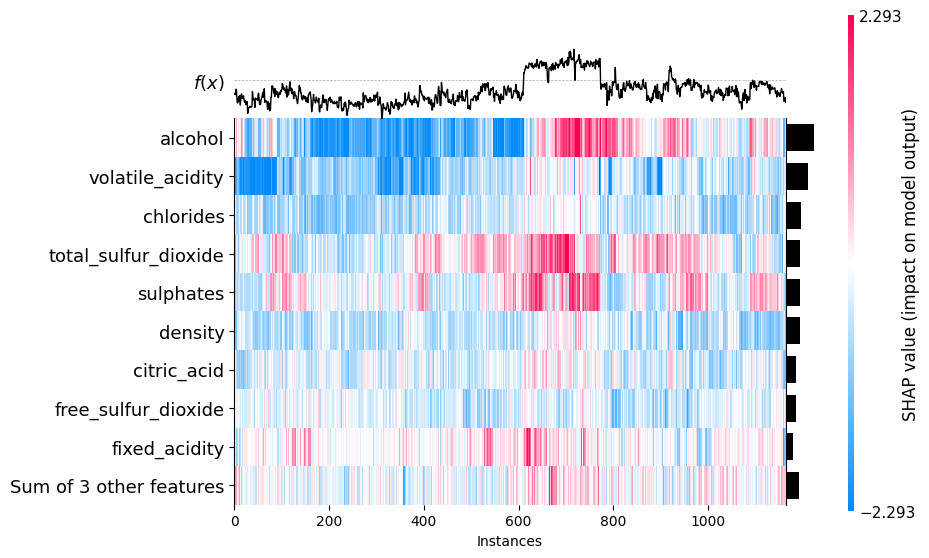

<Axes: xlabel='Instances'>

In [226]:
# Create a SHAP heatmap plot for the worst wines
shap.plots.heatmap(shap_values_worst_expl_white)

## White vs Red

![alt text](white.png)

![alt text](red.png)

# Wrap-up and conclusion

As wrap-up, explain what are your key findings, and make 3 recommendations to the wine maker on how to improve the wines for next year. How confident are you that making these changes will lead to better wines? Explain in simple terms to the winemaker the limitations of your approach in terms of capturing causality.

increasing alcohol content, reducing volatile acidity, and optimizing sulfur dioxide levels can improve wine quality. Alcohol positively impacts both red and white wines, while high volatile acidity harms red wines. To improve next year's wines, slightly raise alcohol levels, lower volatile acidity, and balance sulfur dioxide 

It depends because there is a lot of external elements like weather if there is too much rain and cold whine is gona be acid.

If there is a lots of sun and warm weather and after lots of rain its gonna be bad.